In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
plt.rcParams['figure.figsize'] = 10,10
import numpy as np
from scipy.stats import multivariate_normal

# Number of features of real valued random vector X 
features  = 2

# Number of samples to be generated for the vector
samples = 10000

# Initializing the mean and covariance matrix
mean = np.zeros((features,3))
mean[:,0] = [5,0] # Mean vector of class 0
mean[:,1] = [0,4] # Mean vector of class 0b
mean[:,2] = [3,2] # Mean vector of class 1
cov = np.zeros((features, features, 3))
cov[:,:,0] = [[4,0], [0,2]] # Covariance matrix of class 0 
cov[:,:,1] = [[1,0], [0,3]] # Covariance matrix of class 0b
cov[:,:,2] = [[2,0], [0,2]] # Covariance matix of class 1

# Priors of Class 0 and 1

prior = [0.6, 0.4]
# Different gaussian distribution of class 0
gmm0 = [0.5,0.5]


def plot_data(X,samples,labels):
  '''
  X : Input data
  samples: Number of samples to be generated 
  labels: 
  '''
  x0 = [i for i in range(0,samples) if(labels[0,i] == 0)]
  x1 = [i for i in range(0,samples) if(labels[0,i] == 1)]
  plt.scatter(X[0,x0],X[1,x0],s=5, color = 'black', label = 'class 0',marker='+')
  plt.scatter(X[0,x1],X[1,x1],s=2, color = 'red', label = 'class 1',marker='*')
  plt.title("Actual data distribution")
  plt.xlabel("Feature x1")
  plt.ylabel("Feature x2")
  plt.legend()

def Generate_and_Plot_data(samples):
  #Labels
  labels = np.zeros((2,samples))
  labels[0,:] = (np.random.uniform(0,1,samples) >= prior[0]).astype(int)

  # Data
  X = np.zeros((2,samples))
  for i in range(0,samples):
    if (labels[0,i] == 0):
      if (np.random.uniform(0,1,1) >= gmm0[0]):
        X[:,i] = np.random.multivariate_normal(mean[:,0],cov[:,:,0],1)
      else:
        X[:,i] = np.random.multivariate_normal(mean[:,1],cov[:,:,1],1)
    else:
      X[:,i] = np.random.multivariate_normal(mean[:,2],cov[:,:,2],1)
  plot_data(X,samples,labels)
  return X,labels

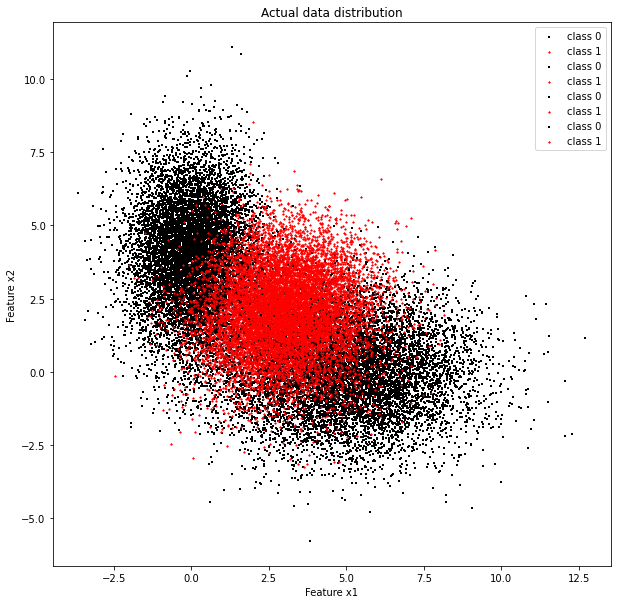

In [3]:
np.random.seed(12)
D_train100,labels_100 = Generate_and_Plot_data(100)
D_train1000,labels_1000 = Generate_and_Plot_data(1000)
D_train10000,labels_10000 = Generate_and_Plot_data(10000)
D_test20000,labels_20000 = Generate_and_Plot_data(20000)

In [4]:
def roc_plt(X, labels,samples):
  class0_count = float(list(labels[0,:]).count(0)) # number of samples for class 0
  class1_count = float(list(labels[0,:]).count(1)) # number of samples for class 1
  fpr =[] # false positive rate array
  tpr = [] # true positive rate array
  minPerror = [] 
  # Creare list of threhold values for plotting ROC curve
  q = list(sorted(X[0,:]))
  gamma_list = []
  for i in range(0,samples-1):
    gamma_list.append((q[i] + q[i+1])/2.0)
    gamma_list = [gamma_list[i] for i in range(0,len(gamma_list)) if gamma_list[i]>=0]
  # Calculate the discriminant score
  logValpdf1 = np.log(multivariate_normal.pdf(X.T,mean=mean[:,2], cov = cov[:,:,2]))
  logValpdf0 = np.log((gmm0[0]*multivariate_normal.pdf(X.T,mean = mean[:,0],cov = cov[:,:,0])) +
                       (gmm0[1]*multivariate_normal.pdf(X.T,mean = mean[:,1],cov = cov[:,:,1])))
  discriminant_score = logValpdf1 - logValpdf0
  for gamma in gamma_list:
    labels[1,:] = (discriminant_score >= np.log(gamma)).astype(int)
    x00 = [i for i in range(labels.shape[1]) if (labels[1,i] == 0 and labels[0,i] == 0)]
    x01 = [i for i in range(labels.shape[1]) if (labels[1,i] == 0 and labels[0,i] == 1)]
    x10 = [i for i in range(labels.shape[1]) if (labels[1,i] == 1 and labels[0,i] == 0)]
    x11 = [i for i in range(labels.shape[1]) if (labels[1,i] == 1 and labels[0,i] == 1)]
    fpr.append(len(x10)/class0_count)
    tpr.append(len(x11)/class1_count)
    minPerror.append(1 - ((len(x00)+len(x11))/10000.0))
  
  plt.plot(fpr,tpr,color = 'red' )
  plt.plot(fpr[np.argmin(minPerror)],tpr[np.argmin(minPerror)],'*',color = 'black')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('ROC Curve')
  plt.annotate(s='Min_P(e) = ' + str(round(minPerror[np.argmin(minPerror)],3)) + '\n'
                                      +'TPR = '+ str(round(tpr[np.argmin(minPerror)],2)) + '\n'
                                      +'FPR = '+ str(round(fpr[np.argmin(minPerror)],2)) + '\n'
                                      +'Gamma = '+ str(round(gamma_list[np.argmin(minPerror)],2)),xy =
                                      (fpr[np.argmin(minPerror)],tpr[np.argmin(minPerror)]),
                                      xytext=(fpr[np.argmin(minPerror)]+0.3,tpr[np.argmin(minPerror)]),
                                      arrowprops=dict(facecolor='black', width = 0.01,headwidth = 5,shrink=0))

  plt.show()
  # Code to plot the distribution after Classification
  labels[1,:] = (discriminant_score >= np.log(gamma_list[np.argmin(minPerror)])).astype(int)
  x00 = [i for i in range(labels.shape[1]) if (labels[0,i] == 0 and labels[1,i] == 0)]
  x01 = [i for i in range(labels.shape[1]) if (labels[0,i] == 0 and labels[1,i] == 1)]
  x10 = [i for i in range(labels.shape[1]) if (labels[0,i] == 1 and labels[1,i] == 0)]
  x11 = [i for i in range(labels.shape[1]) if (labels[0,i] == 1 and labels[1,i] == 1)]
  plt.plot(X[0,x00],X[1,x00],'.',color ='g', markersize = 6)
  plt.plot(X[0,x01],X[1,x01],'.',color = 'r', markersize = 6)
  plt.plot(X[0,x11],X[1,x11],'+',color ='g', markersize = 6)
  plt.plot(X[0,x10],X[1,x10],'+',color = 'r', markersize = 6)
  plt.legend(["class 0 correctly classified",'class 0 wrongly classified','class 1 correctly classified','class 1 wrongly classified'])
  plt.xlabel("Feature x1")
  plt.ylabel("Feature x2")
  plt.title('Distribution after classification overlapped by decision boundaries')


  horizontalGrid = np.linspace(np.floor(min(X[0,:])),np.ceil(max(X[0,:])),101);
  verticalGrid = np.linspace(np.floor(min(X[1,:])),np.ceil(max(X[1,:])),91);
  dsg = np.zeros((91,101))
  a = np.array(np.meshgrid(horizontalGrid,verticalGrid))
  for i in range(91):
    for j in range(101):
      p = multivariate_normal.pdf(np.array([a[0][i][j], a[1][i][j]]),mean= mean[:,2], cov = cov[:,:,2])
      q = (0.5*multivariate_normal.pdf(np.array([a[0][i][j], a[1][i][j]]),mean= mean[:,0], cov = cov[:,:,0]) 
          + 0.5*multivariate_normal.pdf(np.array([a[0][i][j], a[1][i][j]]),mean= mean[:,1], cov = cov[:,:,1]))

      dsg[i][j] = np.log(p) - np.log(q) - np.log(gamma)

  plt.contour(a[0],a[1],dsg)
  plt.show()

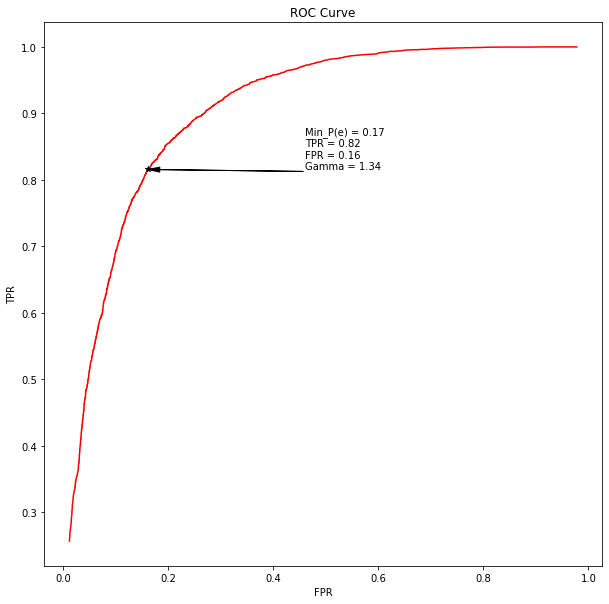

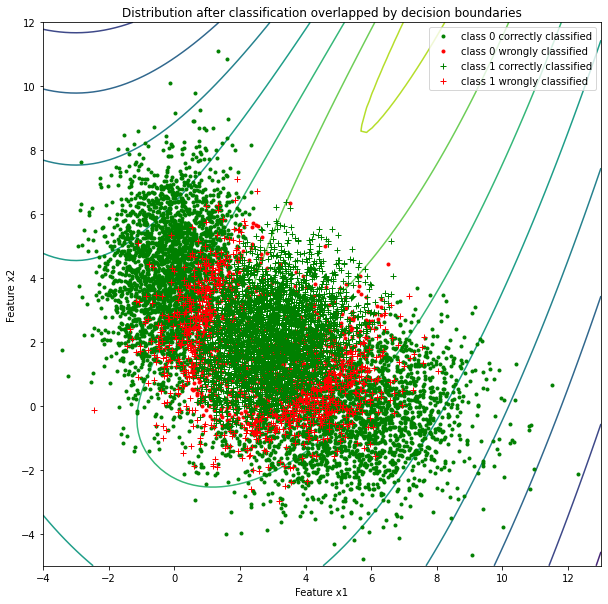

In [14]:
roc_plt(D_train10000,labels_10000,10000)